
Demonstrate the usage of spatialcells for deconvoluted Visium datasets (via cell2location)

@author: Guihong Wan and Boshen Yan      
@date: Feb 6 2024   
@last updated: Feb 6 2024

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import anndata as ad
import scanpy as sc

import spatialcells as spc

# Read data

In [3]:
adata = ad.read_h5ad("../../data/sp_1.h5ad")
adata

AnnData object with n_obs × n_vars = 4035 × 10217
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka ‘at least this amount is present’).

https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html#Visualising-cell-abundance-in-spatial-coordinates

In [6]:
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf']

In [7]:
adata.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample', '_indices',
       '_scvi_batch', '_scvi_labels', 'B_Cycling', 'B_GC_DZ', 'B_GC_LZ',
       'B_GC_prePB', 'B_IFN', 'B_activated', 'B_mem', 'B_naive', 'B_plasma',
       'B_preGC', 'DC_CCR7+', 'DC_cDC1', 'DC_cDC2', 'DC_pDC', 'Endo', 'FDC',
       'ILC', 'Macrophages_M1', 'Macrophages_M2', 'Mast', 'Monocytes', 'NK',
       'NKT', 'T_CD4+', 'T_CD4+_TfH', 'T_CD4+_TfH_GC', 'T_CD4+_naive',
       'T_CD8+_CD161+', 'T_CD8+_cytotoxic', 'T_CD8+_naive', 'T_TIM3+', 'T_TfR',
       'T_Treg', 'VSMC'],
      dtype='object')

In [8]:
# find centroids of each spot, scaled according to image size in pixels to enable overlay
# tissue_hires_scalef: A scaling factor that converts pixel positions in the original, full-resolution image 
# to pixel positions in tissue_hires_image.png.
scalef = adata.uns["spatial"]["V1_Human_Lymph_Node"]["scalefactors"]["tissue_hires_scalef"]
adata.obs["X_centroid"] = adata.obsm["spatial"][:, 0] * scalef
adata.obs["Y_centroid"] = adata.obsm["spatial"][:, 1] * scalef

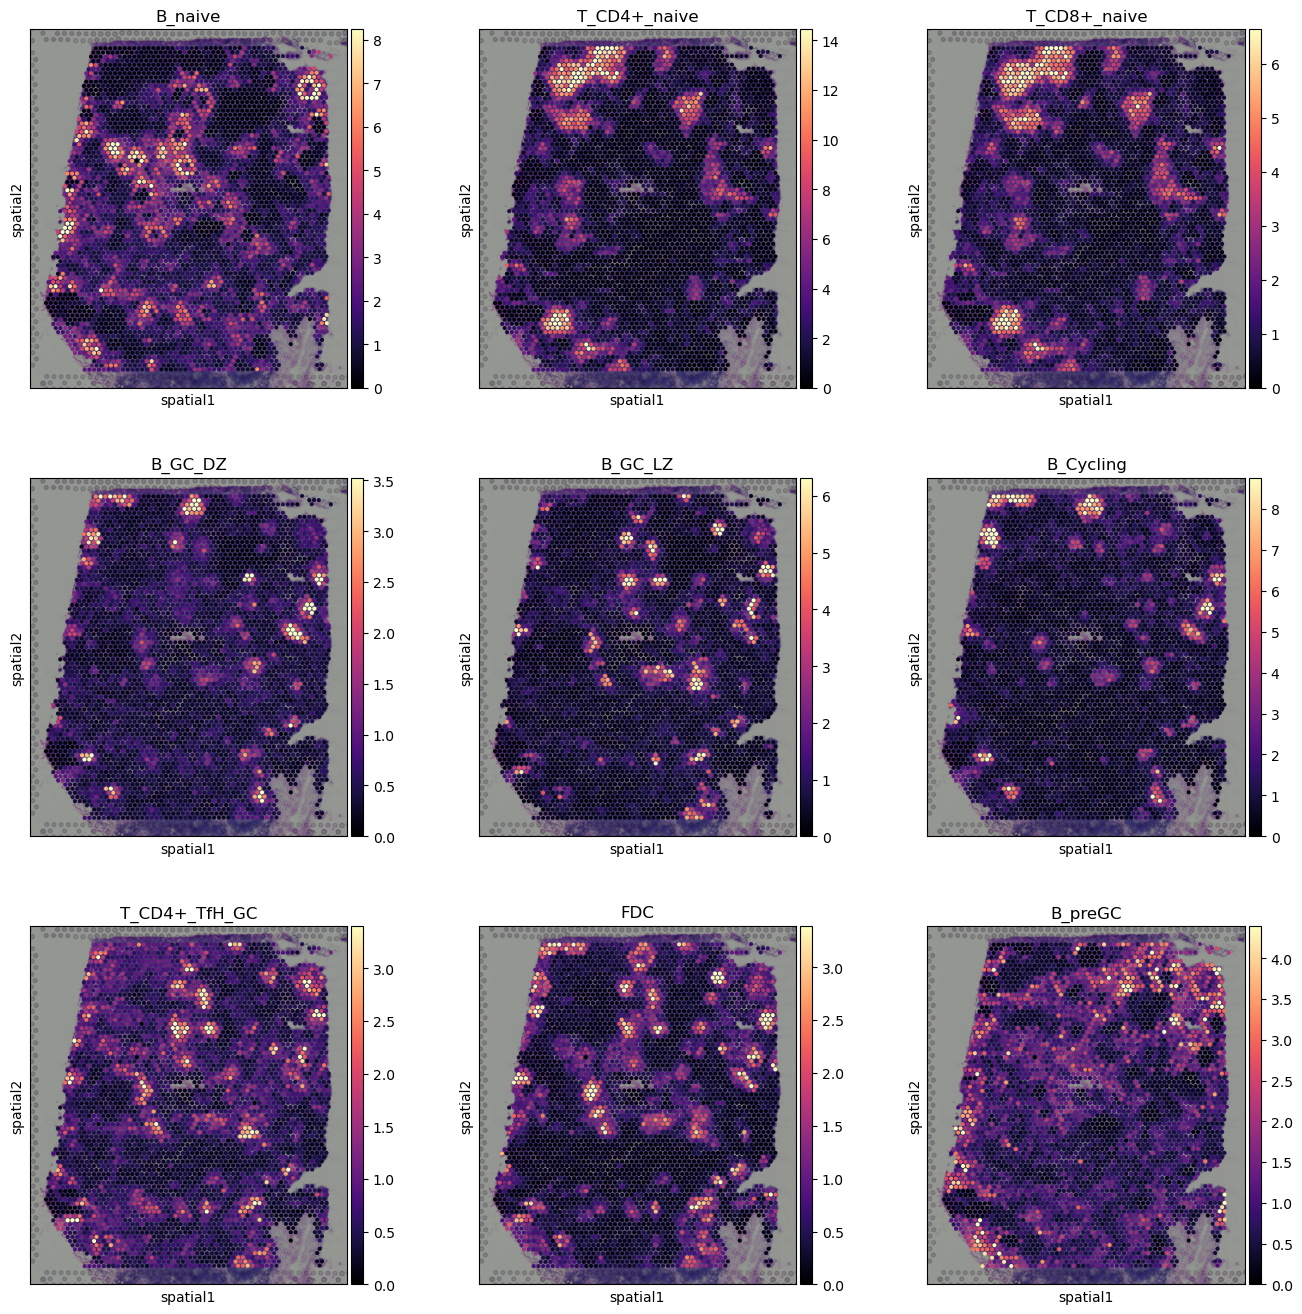

In [9]:

with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(adata, cmap='magma',
                  # show first 8 cell types
                  color=['B_naive',  'T_CD4+_naive', 'T_CD8+_naive',
                         'B_GC_DZ', 'B_GC_LZ', 'B_Cycling', 'T_CD4+_TfH_GC', 'FDC',
                         'B_preGC',],
                  ncols=3, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [10]:
## identify celltype-dense spots. 
## dense spots are defined here as spots of more than 90% quantile in cell type abundance
adata.obs[
    adata.uns['mod']['factor_names'] + "_dense"
    ] = adata.obs[
        adata.uns['mod']['factor_names']
        ] > adata.obs[
            adata.uns['mod']['factor_names']
            ].quantile(0.90)

# Here, we are interested in visualizing the spatial arrangement of germinal centers
# We located germinal centers based on germinal center specific B cell subtypes 
# Which are identified by the Cell2location tutorial pipeline by Kleshchevnikov et al
adata.obs["COI_community"] = (
    adata.obs["B_Cycling_dense"] | 
    adata.obs["B_GC_LZ_dense"] | 
    adata.obs["B_GC_DZ_dense"]
).astype(int)

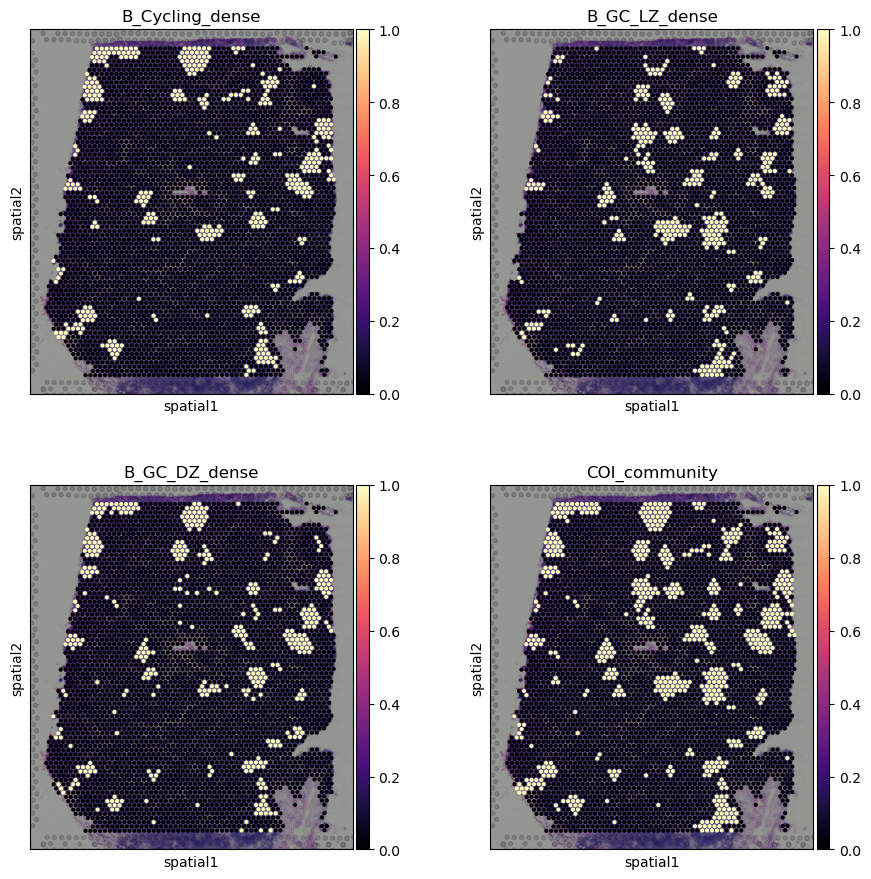

In [11]:
# plotting spots dense in B cell subtypes of interest

adata1 = adata.copy()
adata1.obs["B_Cycling_dense"] = adata1.obs["B_Cycling_dense"].astype(int)
adata1.obs["B_GC_LZ_dense"] = adata1.obs["B_GC_LZ_dense"].astype(int)
adata1.obs["B_GC_DZ_dense"] = adata1.obs["B_GC_DZ_dense"].astype(int)


with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(adata1, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling_dense', 'B_GC_LZ_dense', 'B_GC_DZ_dense', "COI_community"],
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

# getBoundary    

In [12]:
eps_estims = spc.spa.estimateInitialDistance(
    adata, ["COI_community"], sampling_ratio=0.2
)
eps_estims

Computing distances...


[33.36114384870609,
 93.11537188982376,
 321.85548625417425,
 1257.6925339706372,
 3761.444077919561]

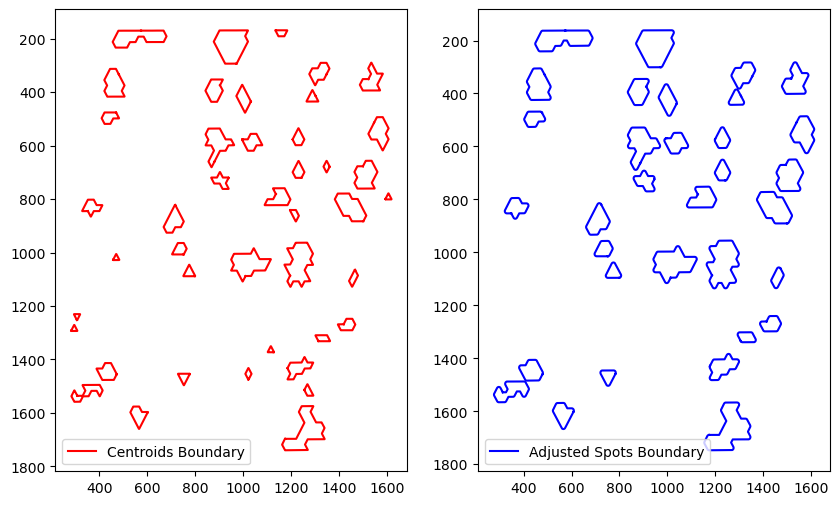

In [13]:
boundary = spc.spa.getBoundary(adata, "COI_community", [1], alpha=eps_estims[0]/2)
# filter out small regions or holes based on the number of edges
# or the area of the region
spot_diameter = adata.uns["spatial"]["V1_Human_Lymph_Node"]["scalefactors"]["spot_diameter_fullres"]
spots_boundary = spc.spa.getExtendedBoundary(boundary, offset=spot_diameter * scalef / 2)

boundary1 = spc.spa.pruneSmallComponents(spots_boundary, min_edges=10, min_area=2000)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,6))
spc.plt.plotBoundary(boundary, ax=ax1, color="r", label="Centroids Boundary")
ax1.invert_yaxis()
ax1.legend()

spc.plt.plotBoundary(boundary1, ax=ax2, color="b", label="Adjusted Spots Boundary")
ax2.invert_yaxis()
ax2.legend()
plt.show()

# assignPointsToRegion

Using 1 or more generated boundaries, cells can be assigned to different regions for downstream analysis

In [14]:
help(spc.spatial.assignPointsToRegions)

Help on function assignPointsToRegions in module spatialcells.spatial._assignPointsToRegions:

assignPointsToRegions(anndata, boundaries_list, region_names, assigncolumn='region', default='BG')
    Assign points to regions based on the boundaries. The region assignment is
    based on the order of the boundaries, so the innermost region should be the
    first element of boundaries_list.
    
    :param anndata: Anndata object
    :param boundaries_list: List of boundaries
    :param region_names: List of region names. The order and length should match boundaries_list
    :param assigncolumn: Column name for the region assignment
    :param default: Default region name for points that are not assigned to any region



In [17]:
regions = ["Germinal Center"]
boundaries_list = [boundary1]

spc.spatial.assignPointsToRegions(
    adata, boundaries_list, regions, assigncolumn="region", default="Background"
)

4012it [00:01, 2979.91it/s]

Assigned points to region: Germinal Center


In [18]:
print("Regions:")
print(adata.obs["region"].cat.categories)
print("\nNumber of points in each region:")
print(adata.obs["region"].value_counts())

Regions:
Index(['Germinal Center', 'Background'], dtype='object')

Number of points in each region:
region
Background         3487
Germinal Center     548
Name: count, dtype: int64


In [19]:

# fig, ax = plt.subplots(figsize=(8,10))
# plt.imshow(adata.uns["spatial"]["V1_Human_Lymph_Node"]["images"]["hires"], alpha=1)

# plt.legend(loc="lower left", markerscale=5)
# plt.savefig('HnE.png', dpi=300)

In [20]:
adata.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'sample', '_indices',
       '_scvi_batch', '_scvi_labels', 'B_Cycling', 'B_GC_DZ', 'B_GC_LZ',
       'B_GC_prePB', 'B_IFN', 'B_activated', 'B_mem', 'B_naive', 'B_plasma',
       'B_preGC', 'DC_CCR7+', 'DC_cDC1', 'DC_cDC2', 'DC_pDC', 'Endo', 'FDC',
       'ILC', 'Macrophages_M1', 'Macrophages_M2', 'Mast', 'Monocytes', 'NK',
       'NKT', 'T_CD4+', 'T_CD4+_TfH', 'T_CD4+_TfH_GC', 'T_CD4+_naive',
       'T_CD8+_CD161+', 'T_CD8+_cytotoxic', 'T_CD8+_naive', 'T_TIM3+', 'T_TfR',
       'T_Treg', 'VSMC', 'X_centroid', 'Y_centroid', 'B_Cycling_dense',
       'B_GC_DZ_dense', 'B_GC_LZ_dense', 'B_GC_prePB_dense', 'B_IFN_dense',
       'B_activated_dense', 'B_mem_dense', 'B_naive_dense', 'B_plasma_dense',
       'B_preGC_dense', 'DC_CCR7+_dense', 'DC_cDC1_dense', 'DC_cDC2_dense',
       'DC_pDC_dense', 'Endo_dense', 'FDC_dense', 'ILC_dense',
       'Macrophages_M1_dense', 'Macrophages_M2_dense', 'Mast_dense',
       'Monocytes_dense', 'NK_dense', 'NKT_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


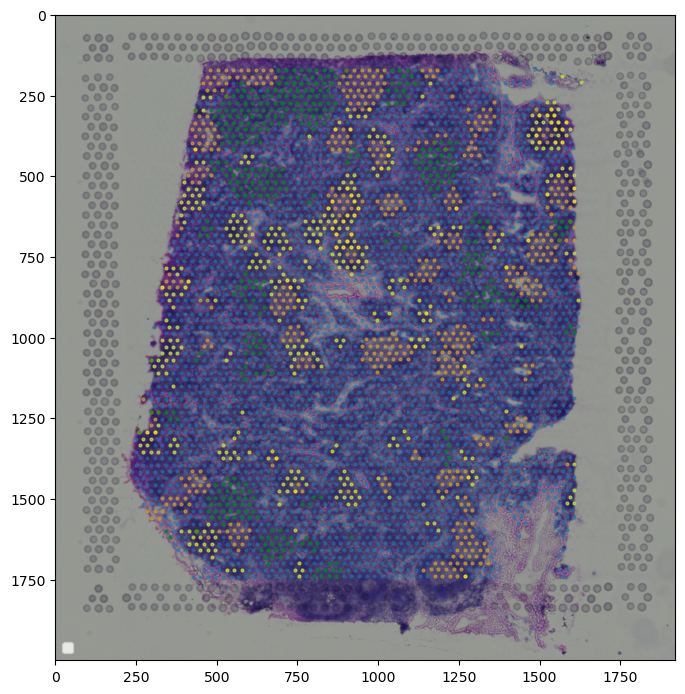

In [21]:
# plotting spots dense in B cell subtypes of interest

adata1 = adata.copy()
adata1.obs["B_Cycling_dense"] = adata1.obs["B_Cycling_dense"].astype(int)
adata1.obs["B_GC_LZ_dense"] = adata1.obs["B_GC_LZ_dense"].astype(int)
adata1.obs["B_GC_DZ_dense"] = adata1.obs["B_GC_DZ_dense"].astype(int)

colors = ["orange", "yellow", "green", "tab:blue"]

point_size = 4
fig, ax = plt.subplots(figsize=(8,10))
plt.imshow(adata.uns["spatial"]["V1_Human_Lymph_Node"]["images"]["hires"], alpha=1)

#All
tmp = adata
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
           s=point_size,
           alpha=0.5,
           color=colors[3]
           )

#GC
tmp = adata[adata.obs.B_Cycling_dense|adata.obs.B_GC_LZ_dense|adata.obs.B_Cycling_dense]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
           s=point_size,
           alpha=0.5,
           color=colors[0]
           )
#B native
tmp = adata[adata.obs.B_naive_dense]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
           s=point_size,
           alpha=0.5,
           color=colors[1]
           )
#T native
tmp = adata[adata.obs["T_CD4+_naive_dense"]|adata.obs["T_CD8+_naive_dense"]]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
           s=point_size,
           alpha=0.5,
           color=colors[2]
           )


plt.legend(loc="lower left", markerscale=5)
plt.show()
# plt.savefig('cells.png', dpi=300)

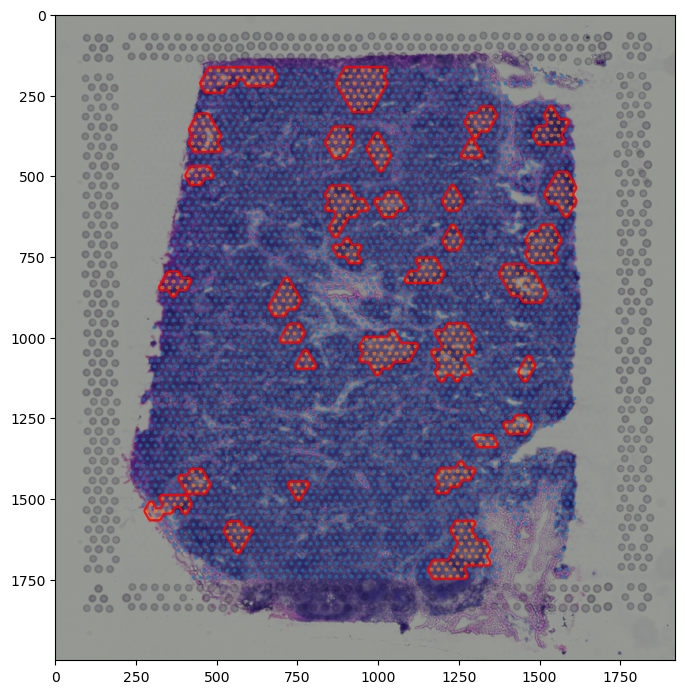

In [22]:
colors = ["tab:orange", "tab:blue", "tab:green", "tab:grey", "tab:red"]

point_size = 4
fig, ax = plt.subplots(figsize=(8,10))
spc.plt.plotBoundary(
    boundary1, color="r", label="Germinal Center Boundary", ax=ax, alpha=0.9
)
# get points in each region in order
for i, region in enumerate(adata.obs["region"].cat.categories):
    tmp = adata[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.5,
        label=region,
        color=colors[i]
    )

plt.imshow(adata.uns["spatial"]["V1_Human_Lymph_Node"]["images"]["hires"], alpha=1)

# plt.legend(loc="lower left", markerscale=5)
plt.show()
# plt.savefig('GC.png', dpi=300) 

In [23]:
## get overall boundary
overall_boundary = spc.spa.getBoundary(adata, "in_tissue", [1], alpha=20)
# filter out small regions or holes based on the number of edges
# or the area of the region
overall_boundary = spc.spa.getExtendedBoundary(overall_boundary, offset=spot_diameter * scalef / 2)
overall_boundary1 = spc.spa.pruneSmallComponents(overall_boundary, min_edges=10, min_area=1000)

# fig, ax1 = plt.subplots(figsize=(5,6))
# spc.plt.plotBoundary(overall_boundary1, ax=ax1, color="r", label="Overall Boundary")
# ax1.legend()
# ax1.invert_yaxis()
# plt.show()

In [24]:
## Helper function to get cell type counts in each region, across several columns
def getRegionCountsMean(adata, regioncol, columns):
    all_counts = []
    for col in columns:
        counts = adata.obs.groupby(regioncol, observed=True)[col].mean()
        all_counts.append(counts)
    return pd.concat(all_counts, axis=1)

def getRegionCounts(adata, regioncol, columns):
    all_counts = []
    for col in columns:
        counts = adata.obs.groupby(regioncol, observed=True)[col].sum()
        all_counts.append(counts)
    return pd.concat(all_counts, axis=1)

In [25]:
raw_estim_mean = getRegionCountsMean(adata, "region", adata.uns['mod']['factor_names'])
percentage_dense = getRegionCounts(adata, "region", adata.uns['mod']['factor_names'] + "_dense")

In [26]:
adata.uns['mod']['factor_names']

array(['B_Cycling', 'B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB', 'B_IFN',
       'B_activated', 'B_mem', 'B_naive', 'B_plasma', 'B_preGC',
       'DC_CCR7+', 'DC_cDC1', 'DC_cDC2', 'DC_pDC', 'Endo', 'FDC', 'ILC',
       'Macrophages_M1', 'Macrophages_M2', 'Mast', 'Monocytes', 'NK',
       'NKT', 'T_CD4+', 'T_CD4+_TfH', 'T_CD4+_TfH_GC', 'T_CD4+_naive',
       'T_CD8+_CD161+', 'T_CD8+_cytotoxic', 'T_CD8+_naive', 'T_TIM3+',
       'T_TfR', 'T_Treg', 'VSMC'], dtype=object)

In [27]:
# mean estimated cell type abundance in each spot for each region
raw_estim_mean

B_Cycling   B_GC_DZ   B_GC_LZ  B_GC_prePB     B_IFN  \
region                                                                 
Germinal Center   3.489793  1.543892  2.812592    0.851064  0.574457   
Background        0.665491  0.384414  0.509018    0.240387  0.718301   

                 B_activated     B_mem   B_naive  B_plasma   B_preGC  ...  \
region                                                                ...   
Germinal Center     0.831627  1.312993  1.608901  0.718583  0.706312  ...   
Background          1.187099  1.957374  1.868405  1.379708  1.140211  ...   

                 T_CD4+_TfH  T_CD4+_TfH_GC  T_CD4+_naive  T_CD8+_CD161+  \
region                                                                    
Germinal Center    0.249425       1.695331      0.686543       0.198562   
Background         0.538775       0.620881      2.324264       0.471576   

                 T_CD8+_cytotoxic  T_CD8+_naive   T_TIM3+     T_TfR    T_Treg  \
region                                                                          
Germinal Center          0.316849      0.391157  0.945408  0.515738  0.293817   
Background               0.488169      1.266793  0.943437  0.662367  0.734309   

                     VSMC  
region                     
Germinal Center  0.403211  
Background       0.756567  

[2 rows x 34 columns]

In [28]:
# percentage of spots in each region that are 
# considered dense with each cell type
percentage_dense

B_Cycling_dense  B_GC_DZ_dense  B_GC_LZ_dense  \
region                                                           
Germinal Center              345            354            365   
Background                    59             50             39   

                 B_GC_prePB_dense  B_IFN_dense  B_activated_dense  \
region                                                              
Germinal Center               340           59                 53   
Background                     64          345                351   

                 B_mem_dense  B_naive_dense  B_plasma_dense  B_preGC_dense  \
region                                                                       
Germinal Center           36             68               1             31   
Background               368            336             403            373   

                 ...  T_CD4+_TfH_dense  T_CD4+_TfH_GC_dense  \
region           ...                                          
Germinal Center  ...                 3                  269   
Background       ...               401                  135   

                 T_CD4+_naive_dense  T_CD8+_CD161+_dense  \
region                                                     
Germinal Center                   5                    1   
Background                      399                  403   

                 T_CD8+_cytotoxic_dense  T_CD8+_naive_dense  T_TIM3+_dense  \
region                                                                       
Germinal Center                       5                   4             36   
Background                          399                 400            368   

                 T_TfR_dense  T_Treg_dense  VSMC_dense  
region                                                  
Germinal Center            5             3           5  
Background               399           401         399  

[2 rows x 34 columns]

In [29]:
## areas (in image pixels):
print("Area of germinal centers:", spc.msmt.getRegionArea(boundary1))
print("Area of tissue sample:", spc.msmt.getRegionArea(overall_boundary1))
print(
    "Percentage area of germinal centers: "
    f"{(spc.msmt.getRegionArea(boundary1) / spc.msmt.getRegionArea(overall_boundary1) * 100):.2f} %"
)

Area of germinal centers: 237973.08060695932
Area of tissue sample: 1907465.6849017586
Percentage area of germinal centers: 12.48 %


In [30]:
## cell type compositions
# for demo for now, only showing naive b cells
print(spc.msmt.getRegionComposition(adata, "B_naive_dense", regions=["Background"]))
print(spc.msmt.getRegionComposition(adata, "B_naive_dense", regions=["Germinal Center"]))

   B_naive_dense  cell_count  composition
0          False        3151     0.903642
1           True         336     0.096358
   B_naive_dense  cell_count  composition
0          False         480     0.875912
1           True          68     0.124088


In [31]:
spc.msmt.getRegionComposition(
    adata, "FDC_dense", 
    regions=["Background"], 
    regioncol="region"
)

FDC_dense  cell_count  composition
0      False        3411     0.978205
1       True          76     0.021795

In [32]:
spc.msmt.getRegionComposition(
    adata, "FDC_dense", 
    regions=["Germinal Center"], 
    regioncol="region"
)

FDC_dense  cell_count  composition
0       True         328      0.59854
1      False         220      0.40146

In [33]:
adata.obs.region.value_counts()

region
Background         3487
Germinal Center     548
Name: count, dtype: int64

Number of components: 33


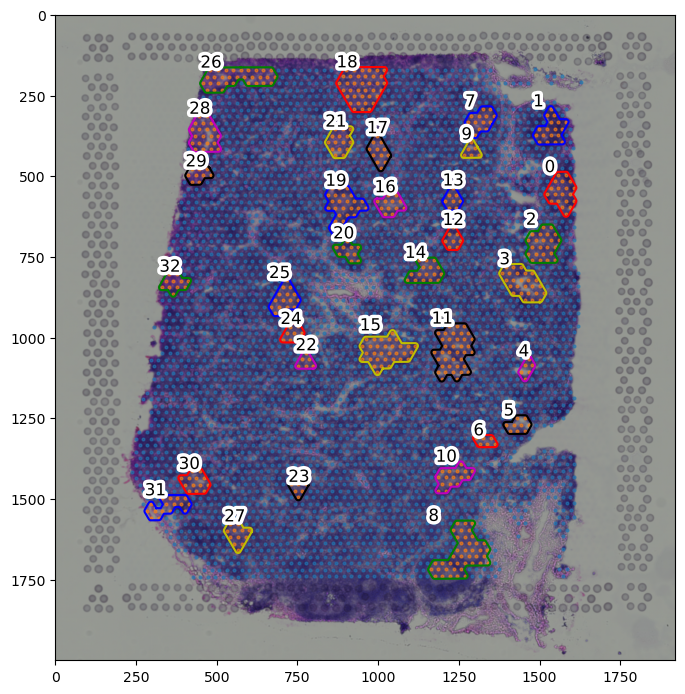

In [34]:
boundary_component_list = spc.spa.getComponents(boundary1)
print("Number of components:", len(boundary_component_list))
fig, ax = plt.subplots(figsize=(8, 10))

for i, region in enumerate(adata.obs["region"].cat.categories):
    tmp = adata[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.6,
        label=region,
        color=colors[i]
    )

spc.plt.plotRegions(
    boundary_component_list,
    colors_list=["r", "b", "g", "y", "m", "k"],
    x_offset=1,
    y_offset=1,
    ax=ax,
)

ax.imshow(adata.uns["spatial"]["V1_Human_Lymph_Node"]["images"]["hires"], alpha=1)

# ax.invert_yaxis()
plt.show()

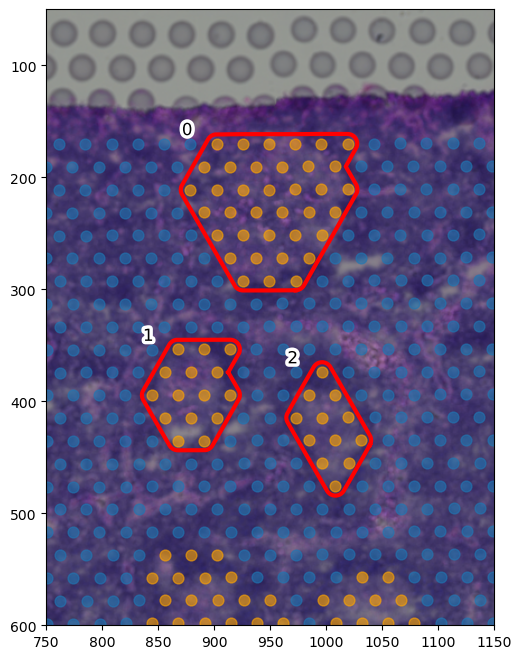

In [35]:
colors = ["orange", "tab:blue", "green", "tab:blue"]

# draw only the 3 germinal centers highlighted in the original paper
selected_center_boundaries = [
    boundary_component_list[18], 
    boundary_component_list[21], 
    boundary_component_list[17]
]

fig, ax = plt.subplots(figsize=(8, 8))

for i, region in enumerate(adata.obs["region"].cat.categories):
    tmp = adata[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
        s=spot_diameter * scalef * 4,
        alpha=0.6,
        label=region,
        color=colors[i]
    )

spc.plt.plotRegions(
    selected_center_boundaries,
    colors_list=["r", "r", "r", "y", "m", "k"],
    x_offset=1,
    y_offset=1,
    ax=ax,
    linewidth=3,
)

ax.imshow(adata.uns["spatial"]["V1_Human_Lymph_Node"]["images"]["hires"], alpha=1)

ax.set_ylim(600, 50)
ax.set_xlim(750, 1150)
# ax.legend()
# ax.invert_yaxis()
plt.show()

136it [00:00, 12964.80it/s]


Assigned points to region: Germinal Center


114it [00:00, 14117.65it/s]


Assigned points to region: Extended Boundary


160it [00:00, 15095.91it/s]

Assigned points to region: Extended Boundary 2


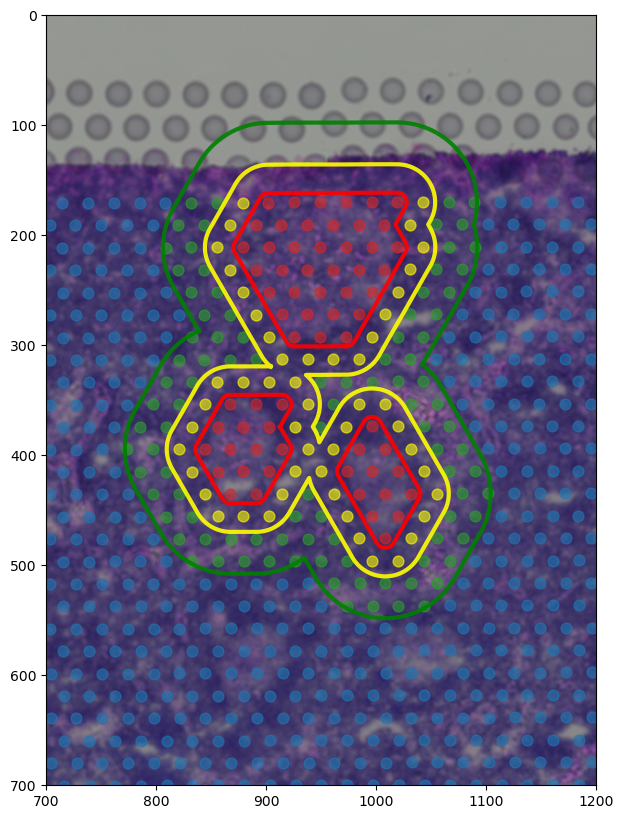

In [36]:
from shapely import MultiPolygon
example_centers_boundary = MultiPolygon([
    boundary_component_list[17].geoms[0],
    boundary_component_list[18].geoms[0],
    boundary_component_list[21].geoms[0],
])

extended_boundary = spc.spa.getExtendedBoundary(example_centers_boundary, offset=spot_diameter * scalef * 1.7)

extended_boundary2 = spc.spa.getExtendedBoundary(extended_boundary, offset=spot_diameter * scalef * 2.5)


regions1 = ["Germinal Center", "Extended Boundary", "Extended Boundary 2"]
boundaries_list1 = [example_centers_boundary, extended_boundary, extended_boundary2]

spc.spatial.assignPointsToRegions(
    adata, boundaries_list1, regions1, assigncolumn="selectRegion", default="Background"
)


fig, ax = plt.subplots(figsize=(8, 10))

# colors = [ "tab:red","tab:blue", "tab:blue", "tab:blue"]
colors = [ "tab:red","yellow", "tab:green", "tab:blue"]

for i, region in enumerate(adata.obs["selectRegion"].cat.categories):
    tmp = adata[adata.obs["selectRegion"] == region]
    ax.scatter(
        *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
        s=spot_diameter * scalef * 4,
        alpha=0.6,
        label=region,
        color=colors[i]
    )

spc.plt.plotBoundary(
    example_centers_boundary, color="r", label="Germinal Center Boundary", ax=ax, alpha=0.9, linewidth=3
)
spc.plt.plotBoundary(
    extended_boundary, color="yellow", label="Extended Boundary", ax=ax, alpha=0.9, linewidth=3
)
spc.plt.plotBoundary(
    extended_boundary2, color="g", label="Extended Boundary 2", ax=ax, alpha=0.9, linewidth=3
)
ax.invert_yaxis()
# ax.legend()
ax.imshow(adata.uns["spatial"]["V1_Human_Lymph_Node"]["images"]["hires"], alpha=1)
ax.set_ylim(700, 0)
ax.set_xlim(700, 1200)
plt.show()

In [190]:
select_raw_estim_mean = getRegionCounts(adata, "selectRegion", adata.uns['mod']['factor_names'])
select_percentage_dense = getRegionCounts(adata, "selectRegion", adata.uns['mod']['factor_names'] + "_dense")

In [191]:
select_raw_estim_mean

B_Cycling      B_GC_DZ      B_GC_LZ   B_GC_prePB  \
selectRegion                                                              
Germinal Center       286.902964   113.064673   159.679207    51.245447   
Extended Boundary      46.554121    27.333019    40.321693    16.738548   
Extended Boundary 2    87.158340    32.426226    39.669068    24.924477   
Background           3812.358491  2013.681578  3076.577213  1211.702830   

                           B_IFN  B_activated        B_mem      B_naive  \
selectRegion                                                              
Germinal Center        23.273735    43.106062    66.509449    79.642546   
Extended Boundary      40.212077    71.434094   154.702069   140.014732   
Extended Boundary 2    99.335584    88.471167   144.949332   124.572365   
Background           2656.696160  4392.135409  7178.721235  7052.576379   

                        B_plasma      B_preGC  ...   T_CD4+_TfH  \
selectRegion                                   ...                
Germinal Center        51.496140    49.612274  ...    17.269178   
Extended Boundary      48.803659    74.105153  ...    26.607056   
Extended Boundary 2   118.408322   152.365655  ...    66.516513   
Background           4986.118130  4086.893288  ...  1905.000187   

                     T_CD4+_TfH_GC  T_CD4+_naive  T_CD8+_CD161+  \
selectRegion                                                      
Germinal Center         111.767758     52.921448      12.987905   
Extended Boundary        49.270372    125.810323      21.887633   
Extended Boundary 2      61.398461    371.280319      56.007545   
Background             2871.617469   7930.921863    1662.313938   

                     T_CD8+_cytotoxic  T_CD8+_naive      T_TIM3+        T_TfR  \
selectRegion                                                                    
Germinal Center             18.707585     29.394039    61.963411    37.720135   
Extended Boundary           22.388177     66.206820    52.500484    41.552343   
Extended Boundary 2         48.345026    195.484460   117.901923    91.279761   
Background                1786.438468   4340.574597  3575.483885  2421.745253   

                          T_Treg         VSMC  
selectRegion                                   
Germinal Center        21.032434    25.728872  
Extended Boundary      41.759977    34.385885  
Extended Boundary 2   101.936597    74.761433  
Background           2556.818049  2724.234355  

[4 rows x 34 columns]

In [192]:
select_percentage_dense1 = select_percentage_dense.transpose().sort_values(["Germinal Center", "Extended Boundary"], ascending=False).transpose()

In [193]:
select_percentage_dense1.columns

Index(['B_GC_DZ_dense', 'B_Cycling_dense', 'B_GC_prePB_dense', 'FDC_dense',
       'B_GC_LZ_dense', 'T_CD4+_TfH_GC_dense', 'Macrophages_M1_dense',
       'DC_cDC1_dense', 'B_naive_dense', 'B_activated_dense', 'B_preGC_dense',
       'T_TIM3+_dense', 'B_mem_dense', 'B_IFN_dense', 'T_CD4+_dense',
       'T_TfR_dense', 'T_CD4+_naive_dense', 'T_Treg_dense', 'NKT_dense',
       'NK_dense', 'DC_CCR7+_dense', 'DC_cDC2_dense', 'DC_pDC_dense',
       'Endo_dense', 'T_CD8+_naive_dense', 'T_CD8+_CD161+_dense', 'VSMC_dense',
       'T_CD4+_TfH_dense', 'B_plasma_dense', 'ILC_dense', 'Monocytes_dense',
       'T_CD8+_cytotoxic_dense', 'Macrophages_M2_dense', 'Mast_dense'],
      dtype='object')

In [194]:
select_percentage_dense1 =select_percentage_dense[[
    'B_GC_LZ_dense', 'B_GC_DZ_dense', 'B_Cycling_dense', 'B_GC_prePB_dense',
    'FDC_dense', 'T_CD4+_TfH_GC_dense', 
    'B_naive_dense', 'B_mem_dense', 'B_activated_dense', 'B_IFN_dense', 
    'T_TfR_dense', 'T_CD4+_dense', 'T_CD4+_naive_dense','DC_CCR7+_dense',
    'T_Treg_dense', 'T_CD8+_naive_dense', 
    'Monocytes_dense', 'Endo_dense', 'VSMC_dense','Mast_dense', 'NKT_dense', 'B_plasma_dense'
]]

In [204]:
select_percentage_dense1.loc["Germinal Center"] = select_percentage_dense1.loc["Germinal Center"]/select_percentage_dense1.loc["Germinal Center"].sum()


/var/folders/yq/bvcgx2bj2vxc85dbxy5ppb4m0000gn/T/ipykernel_17224/3256706615.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12313432835820895' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  select_percentage_dense1.loc["Germinal Center"] = select_percentage_dense1.loc["Germinal Center"]/select_percentage_dense1.loc["Germinal Center"].sum()
/var/folders/yq/bvcgx2bj2vxc85dbxy5ppb4m0000gn/T/ipykernel_17224/3256706615.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19029850746268656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  select_percentage_dense1.loc["Germinal Center"] = select_percentage_dense1.loc["Germinal Center"]/select_percentage_dense1.loc["Germinal Center"].sum()
/var/folders/yq/bvcgx2bj2vxc85dbxy5ppb4m0000gn/T/ipyke

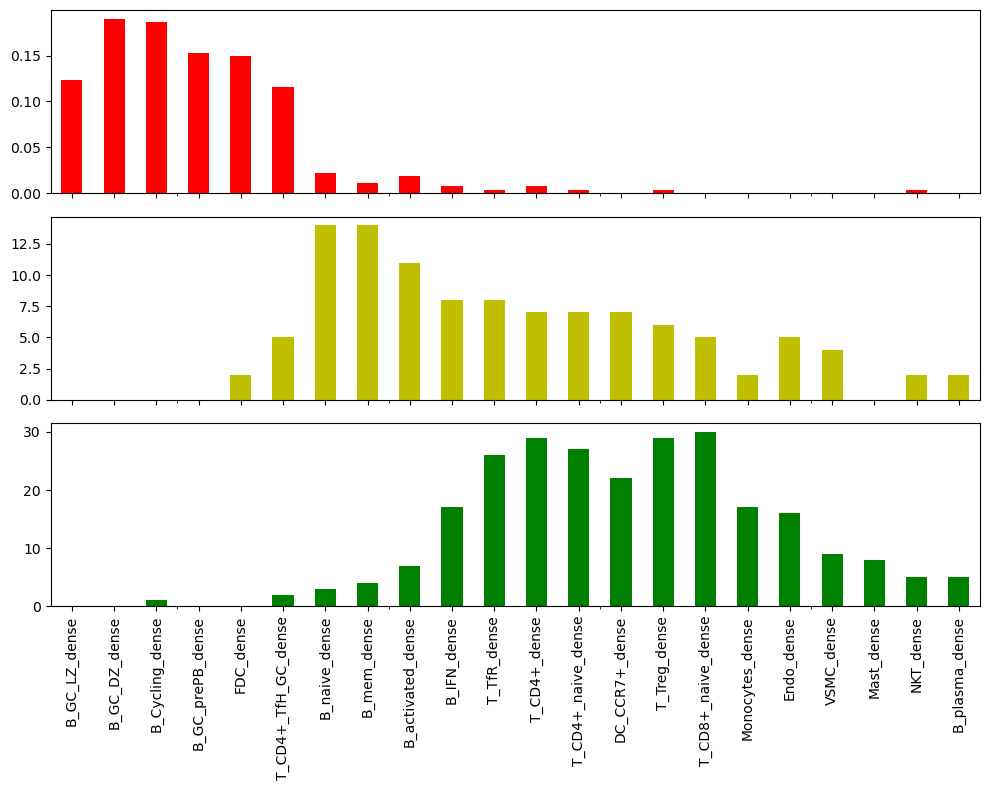

In [207]:
fig, axs = plt.subplots(3,1, figsize=(10, 8), sharex=True)

select_percentage_dense1.loc["Germinal Center"].plot(kind="bar", ax=axs[0], color="r")
# axs[0].set_title("Germinal Center", fontsize=12)
# axs[0].set_ylim([0, 55])

select_percentage_dense1.loc["Extended Boundary"].plot(kind="bar", ax=axs[1], color="y")
# axs[1].set_title("Extended Boundary Region")
# axs[1].set_ylim([0, 55])

select_percentage_dense1.loc["Extended Boundary 2"].plot(kind="bar", ax=axs[2], color="g")
# axs[2].set_title("Extended Boundary 2 Region")
# axs[2].set_ylim([0, 55])


# fig.set_ylabel("Percentage of Dense Spots")
# select_percentage_dense1.loc["Background"].plot(kind="bar", ax=axs[3], color="gray")
# axs[3].set_title("Background Region")
# axs[3].set_xlabel("Cell Type")
plt.tight_layout()
plt.show()

In [136]:
# fig, axs = plt.subplots(4,1, figsize=(10, 8), sharex=True)
# select_percentage_dense.loc["Germinal Center"].plot(kind="bar", ax=axs[0], color="r")
# select_percentage_dense.loc["Extended Boundary"].plot(kind="bar", ax=axs[1], color="b")
# select_percentage_dense.loc["Extended Boundary 2"].plot(kind="bar", ax=axs[2], color="g")
# select_percentage_dense.loc["Background"].plot(kind="bar", ax=axs[3], color="k")
# axs[3].set_xlabel("Cell Type")
# plt.show()